In [44]:
!pip install tensorflow pandas matplotlib sklearn gradio jinja2

^C


## Import Dependencies

In [38]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

## Load Dataset

In [4]:
df = pd.read_csv(os.path.join('train.csv', 'train.csv'))

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
df.iloc[1]['comment_text']

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

## Preprocess and Vectorization

In [9]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [11]:
MAX_WORDS = 200000

In [12]:
vectorizer = TextVectorization(max_tokens=MAX_WORDS, 
                               output_sequence_length=1800, 
                               output_mode='int')

In [13]:
vectorizer.adapt(X.values)

In [15]:
vectorized_text = vectorizer(X.values)

In [16]:
len(X), vectorized_text

(159571,
 <tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
 array([[  643,    76,     2, ...,     0,     0,     0],
        [    1,    54,  2506, ...,     0,     0,     0],
        [  425,   440,    70, ...,     0,     0,     0],
        ...,
        [32141,  7329,   383, ...,     0,     0,     0],
        [    5,    12,   533, ...,     0,     0,     0],
        [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>)

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [18]:
dataset.as_numpy_iterator().next()

(array([[    8,    74,     6, ...,     0,     0,     0],
        [   86,     8,    77, ...,     0,     0,     0],
        [89529,  7835,   248, ...,     0,     0,     0],
        ...,
        [    8,   153,  5956, ...,     0,     0,     0],
        [  220,     9,    15, ...,     0,     0,     0],
        [   64,     9,    61, ...,     0,     0,     0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

In [19]:
train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [20]:
len(train), len(val), len(test)

(6981, 1994, 997)

In [21]:
train_generator = train.as_numpy_iterator()

## Creating Model

In [25]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

## Model Training

In [29]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 4737s 679ms/step - loss: 0.0480 - val_loss: 0.0437
Epoch 2/10
6981/6981 [==============================] - 5177s 742ms/step - loss: 0.0421 - val_loss: 0.0401
Epoch 3/10
6981/6981 [==============================] - 4164s 597ms/step - loss: 0.0379 - val_loss: 0.0334
Epoch 4/10
6981/6981 [==============================] - 4134s 592ms/step - loss: 0.0344 - val_loss: 0.0301
Epoch 5/10
6981/6981 [==============================] - 4120s 590ms/step - loss: 0.0309 - val_loss: 0.0279
Epoch 6/10
6981/6981 [==============================] - 4114s 589ms/step - loss: 0.0281 - val_loss: 0.0244
Epoch 7/10
6981/6981 [==============================] - 4110s 589ms/step - loss: 0.0255 - val_loss: 0.0216
Epoch 8/10
6981/6981 [==============================] - 4100s 587ms/step - loss: 0.0227 - val_loss: 0.0192
Epoch 9/10
6981/6981 [==============================] - 4126s 591ms/step - loss: 0.0204 - val_loss: 0.0166
Epoch 10/10
6981/6981 [==============

In [30]:
history.history

{'loss': [0.048019248992204666,
  0.042071741074323654,
  0.03785223141312599,
  0.034355513751506805,
  0.030892927199602127,
  0.02809244766831398,
  0.025537462905049324,
  0.022654181346297264,
  0.020384836941957474,
  0.01793990470468998],
 'val_loss': [0.04371865466237068,
  0.04013124853372574,
  0.03342355042695999,
  0.030076971277594566,
  0.02786339819431305,
  0.024373145774006844,
  0.021558765321969986,
  0.019228560850024223,
  0.016567956656217575,
  0.015460350550711155]}

<Figure size 1600x500 with 0 Axes>

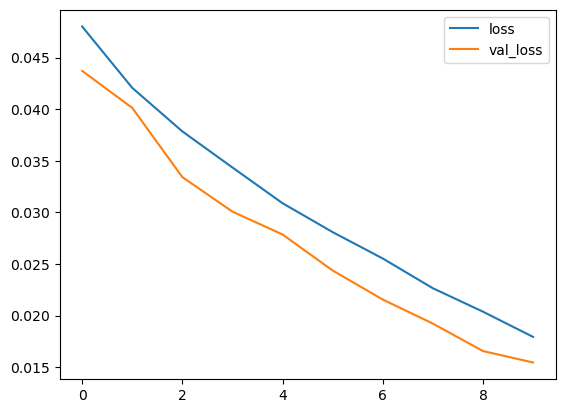

In [34]:
plt.figure(figsize=(16, 5))
pd.DataFrame(history.history).plot()
plt.show()

## Making Predictions

In [35]:
input_text = vectorizer('You Suck!')

In [36]:
batch = test.as_numpy_iterator().next()
res = model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 3s 3s/step


In [37]:
res

array([[9.9932569e-01, 7.4560486e-02, 9.9108493e-01, 1.2279853e-04,
        7.1572906e-01, 4.1659693e-03]], dtype=float32)

## Evaluation

In [39]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [40]:
batch = test.as_numpy_iterator().next()

In [41]:
for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    yhat = model.predict(X_true)
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 92ms/step


In [42]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9295965433120728, Recall: 0.927336573600769, Accuracy: 0.48846539855003357


In [47]:
model.save('Toxic.h5')

## Testing

In [45]:
!pip install gradio jinja2

Defaulting to user installation because normal site-packages is not writeable
  Using cached gradio-3.16.2-py3-none-any.whl (14.2 MB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.10.1 requires keras<2.11,>=2.10.0, but you have keras 2.11.0 which is incompatible.
tensorflow-gpu 2.10.1 requir

Defaulting to user installation because normal site-packages is not writeable
  Using cached gradio-3.16.2-py3-none-any.whl (14.2 MB)
  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached orjson-3.8.5-cp39-none-win_amd64.whl (202 kB)
  Using cached pydantic-1.10.4-cp39-cp39-win_amd64.whl (2.1 MB)
  Using cached fastapi-0.89.1-py3-none-any.whl (55 kB)
  Using cached uvicorn-0.20.0-py3-none-any.whl (56 kB)
  Using cached python_multipart-0.0.5-py3-none-any.whl
  Using cached pycryptodome-3.16.0-cp35-abi3-win_amd64.whl (1.7 MB)
  Using cached aiofiles-22.1.0-py3-none-any.whl (14 kB)
  Using cached markdown_it_py-2.1.0-py3-none-any.whl (84 kB)
  Using cached aiohttp-3.8.3-cp39-cp39-win_amd64.whl (323 kB)
  Using cached httpx-0.23.3-py3-none-any.whl (71 kB)
  Using cached altair-4.2.2-py3-none-any.whl (813 kB)
  Using cached aiosignal-1.3.1-

In [46]:
import gradio as gr

In [48]:
model = tf.keras.models.load_model('toxic.h5')

In [49]:
input_str = vectorizer('I hate you!')
res = model.predict(np.expand_dims(input_str, 0))
res

1/1 [==============================] - 1s 650ms/step


array([[0.8278506 , 0.00111407, 0.03413954, 0.00232714, 0.10825977,
        0.01874559]], dtype=float32)

In [50]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [51]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2: -1]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
        
    return text

In [52]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Write Comment here!'),
                         outputs='text')

C:\Users\kusha\AppData\Roaming\Python\Python39\site-packages\gradio\inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\kusha\AppData\Roaming\Python\Python39\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\kusha\AppData\Roaming\Python\Python39\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [53]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://0d27810f-b27e-452b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 67ms/step
